## Code Demo

- Code demo for paper ``Conformalized Tensor Completion with Riemannian Optimization"

### 0. Load Modules

In [1]:
from Conformal import *
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm

from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor

import warnings
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)

#### 0.1 Helper Functions

In [2]:
def tensor_3d_plot(input_tensor, ax=None, cmap="RdBu_r", vmin=-2.0, vmax=2.0):
    '''
    plot 3d tensor
    '''
    
    colormap = cm.get_cmap(cmap)
    vmin = vmin if not vmin is None else np.amin(input_tensor)
    vmax = vmax if not vmax is None else np.amax(input_tensor)
    color_tensor = colormap((input_tensor - vmin) / (vmax - vmin))[:,:,:,:-1] # take the RGB value
    
    # plot the tensor
    if ax is None:
        ax = plt.figure().add_subplot(projection='3d')
    ax.view_init(elev=30, azim=45)
    ax.voxels(input_tensor, facecolors=color_tensor, edgecolor=(0, 0, 0, 0.1), shade=False)
    ax.axis('off')
    
    return ax

### 1. Simulate Data

#### 1.1 Simulate Tensor $\mathcal{B}$

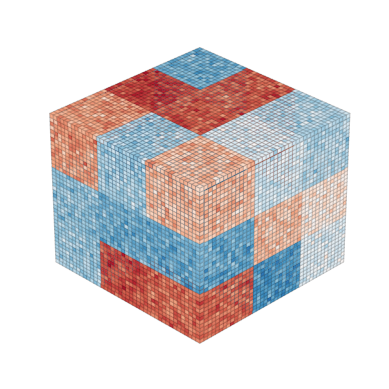

In [3]:
# simulate B tensor
sim = SimIsing(d=(40,40,40), 
               g_func="product", 
               h_func="logit", 
               nb="1-nb", 
               g_params={"temp": 15, "scale": 1/2})

B = sim.sim_B(rank=(3,3), method="tensor-train", seed=2024, tensor_type="checkerbox")
ax = tensor_3d_plot(B)

#### 1.2 Simulate Data Missingness Tensor $\mathcal{W}$ (block-Gibbs)

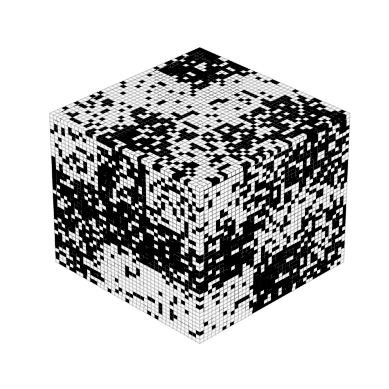

In [4]:
sample = sim.sim_sample(method="Block-Gibbs", 
                        method_params={"max_iter": 40000, "burn_in": 10000, "N_sample": 30}, 
                        seed=2024)

ax = tensor_3d_plot(sample[-1], 
                    cmap="gray", 
                    vmin=-1.0, 
                    vmax=1.0)

In [14]:
# train-calibration split
q = 0.7
train = np.zeros_like(sample)

for i in range(sample.shape[0]):
    W = sample[i]
    np.random.seed(i)
    mask = (np.random.uniform(size=W.shape) <= q)
    train[i,:,:,:] = np.logical_and(mask == 1, W == 1)

### 2. Fitting Tensor Decomposition Model

In [6]:
# Test Fitting Model
model = LRIsing(g_func="product", 
                h_func="logit", 
                nb="1-nb", 
                true_B=B, 
                g_params={"temp": 15, "scale": 1/5})

model.fit(sample[-1], rank=(3,3), method=sim.B_method, config={"max_iter": 200, "thres": 1e-4})    

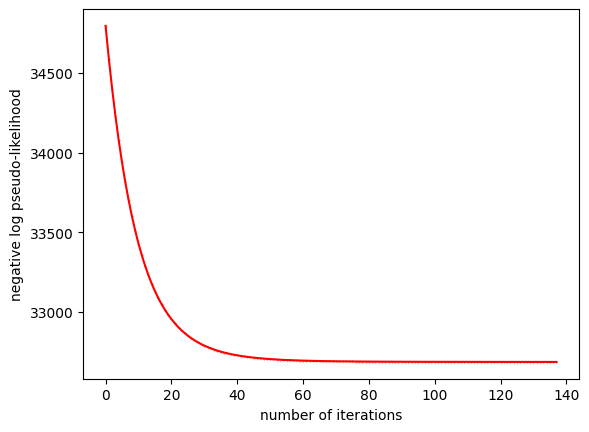

In [7]:
# plot the history of negative log pseudo-likelihood
plt.plot(model.NLL_hist, "r.-", markersize=0.5);
plt.xlabel("number of iterations");
plt.ylabel("negative log pseudo-likelihood");

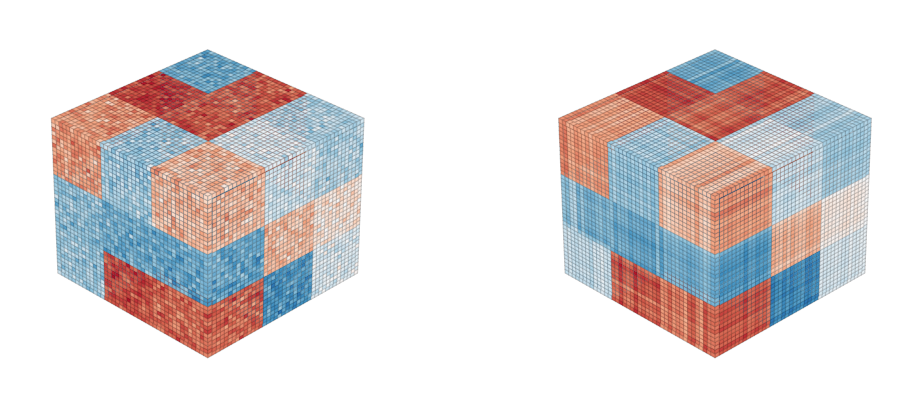

In [8]:
# visualize the fitted result
fig, ax = plt.subplots(nrows=1, 
                       ncols=2, 
                       figsize=(12, 5), 
                       subplot_kw={'projection': '3d'})

im0 = tensor_3d_plot(B, ax[0]);
im1 = tensor_3d_plot(model.B, ax[1]);

### 3. Conformal Inference

In [11]:
# simulate data tensor
simdata = SimData(d=(40,40,40))
X_true, X_noise = simdata.sim_X(rank=(3,3), 
                                seed=2024, 
                                noise="adversarial", 
                                sigma=1.0, 
                                true_B=B, 
                                SNR=2.0, 
                                tensor_type="checkerbox")

i = 0
X_true = X_true + X_noise
X = np.copy(X_true)
W = sample[i]
X[W==-1] = np.nan

In [15]:
cov_probs, widths, inf_probs = {}, {}, {}
for weight in ["unweighted", "oracle", "RGrad"]:
    CTC =  ConfTC(g_func='product', 
                  h_func="logit", 
                  g_params={'temp': 15, 'scale': 1/2}, 
                  nb="1-nb", 
                  true_B=B, 
                  q=0.7)
    
    cov_prob, width, inf_prob = CTC.fit(X, 
                                        train[i],
                                        tc_params={"true_X": X_true, "rank": (3,3,3), "method": "tucker"}, 
                                        dc_params={"rank": (3,3), "method": "tensor-train", "fitted_B": None}, 
                                        weight=weight, 
                                        target_q=np.linspace(0.80,0.99,20), 
                                        invtemp=1/15, 
                                        seed=0,
                                        normalized_ncs=False, 
                                        two_sided=False)
    cov_probs[weight] = cov_prob
    widths[weight] = width
    inf_probs[weight] = inf_prob

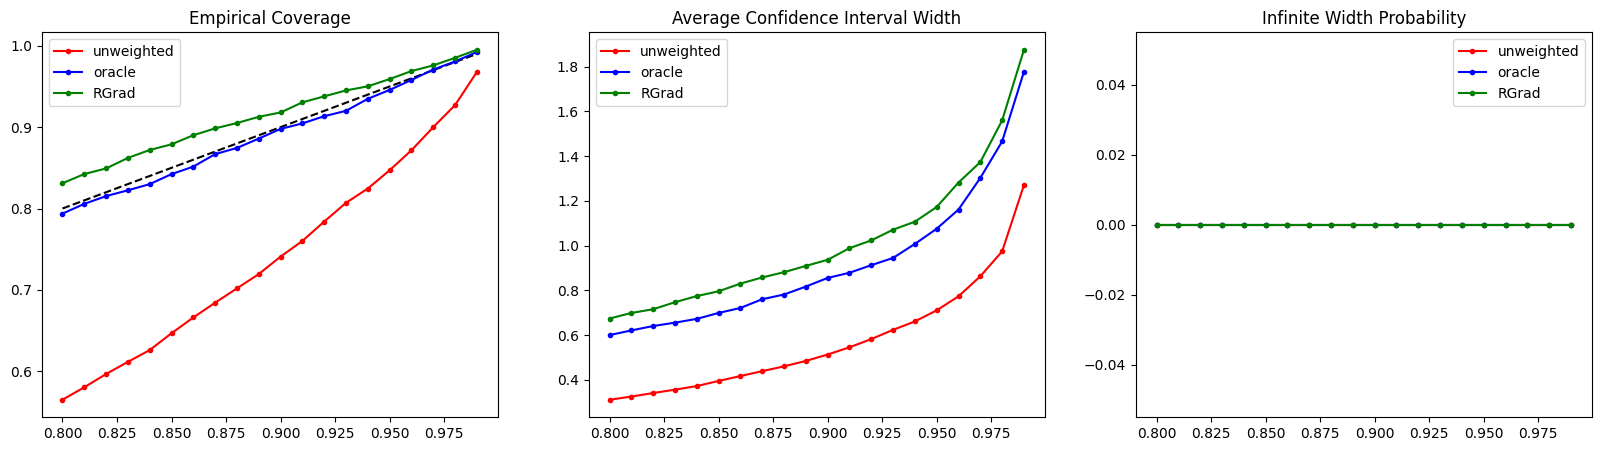

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].plot(np.linspace(0.80,0.99,20), np.linspace(0.80,0.99,20), "k--");
ax[0].plot(np.linspace(0.80,0.99,20), cov_probs["unweighted"], "r.-", label="unweighted");
ax[0].plot(np.linspace(0.80,0.99,20), cov_probs["oracle"], "b.-", label="oracle");
ax[0].plot(np.linspace(0.80,0.99,20), cov_probs["RGrad"], "g.-", label="RGrad");
ax[0].legend();
ax[0].set_title("Empirical Coverage");


ax[1].plot(np.linspace(0.80,0.99,20), widths["unweighted"], "r.-", label="unweighted");
ax[1].plot(np.linspace(0.80,0.99,20), widths["oracle"], "b.-", label="oracle");
ax[1].plot(np.linspace(0.80,0.99,20), widths["RGrad"], "g.-", label="RGrad");
ax[1].legend();
ax[1].set_title("Average Confidence Interval Width");


ax[2].plot(np.linspace(0.80,0.99,20), inf_probs["unweighted"], "r.-", label="unweighted");
ax[2].plot(np.linspace(0.80,0.99,20), inf_probs["oracle"], "b.-", label="oracle");
ax[2].plot(np.linspace(0.80,0.99,20), inf_probs["RGrad"], "g.-", label="RGrad");
ax[2].legend();
ax[2].set_title("Infinite Width Probability");